In [ ]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Helps to obtain the FFT
import scipy.fftpack    
# Various operations on signals (waveforms)
import scipy.signal as signal

In [ ]:
dataset = pd.read_csv("ecg_data.csv",header = None)
y = [e for e in dataset[0]]

In [ ]:
# Number of samplepoints
N = len(y)
# sample spacing
Fs = 1000
T = 1 / Fs
#Compute x-axis
x = np.linspace(0.0, N*T, N)

In [ ]:
yf = scipy.fftpack.fft(y)
#Compute frequency x-axis
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

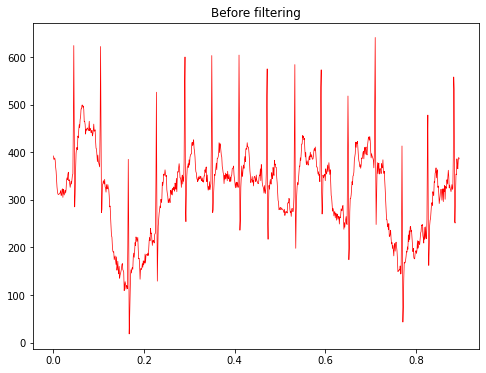

In [ ]:
plt.figure(figsize = (8,6))
plt.title('Before filtering')
plt.plot(x,y, color='r', linewidth=0.7)

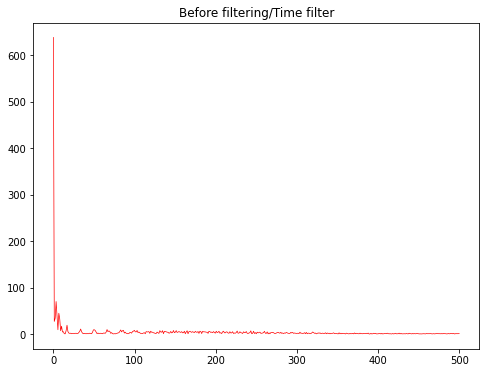

In [ ]:
plt.figure(figsize = (8,6))
plt.title('Before filtering/Time filter')
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='r', linewidth=0.7, label='raw')

In [ ]:
b, a = signal.butter(4, 50/(Fs/2), 'low')

In [ ]:
#Compute filtered signal
tempf = signal.filtfilt(b,a, y)
yff = scipy.fftpack.fft(tempf)

In [ ]:
### Compute Kaiser window co-effs to eliminate baseline drift noise ###
nyq_rate = Fs/ 2.0
# The desired width of the transition from pass to stop.
width = 5.0/nyq_rate
# The desired attenuation in the stop band, in dB.
ripple_db = 60.0
# Compute the order and Kaiser parameter for the FIR filter.
O, beta = signal.kaiserord(ripple_db, width)
# The cutoff frequency of the filter.
cutoff_hz = 4.0
###Use firwin with a Kaiser window to create a lowpass FIR filter.###
taps = signal.firwin(O, cutoff_hz/nyq_rate, window=('kaiser', beta), pass_zero=False)
# Use lfilter to filter x with the FIR filter.
y_filt = signal.lfilter(taps, 1.0, tempf)
yff = scipy.fftpack.fft(y_filt)

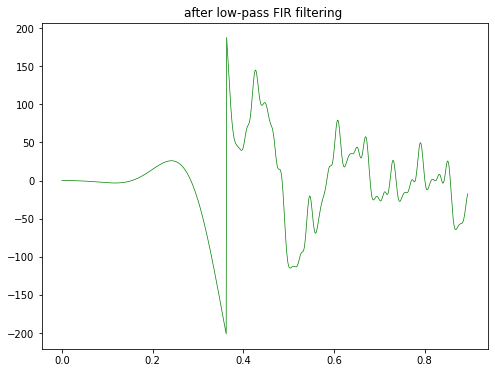

In [ ]:
plt.figure(figsize = (8,6))
plt.title('after low-pass FIR filtering ') 
plt.plot(x,y_filt, color='g', linewidth=0.7)

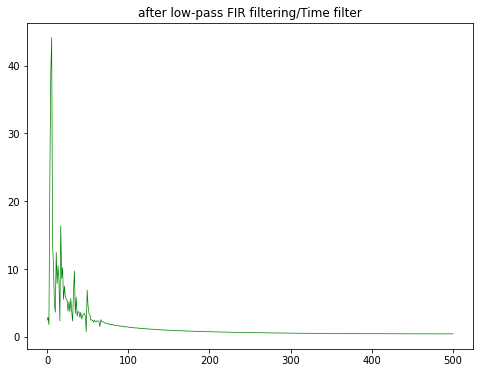

In [ ]:
plt.figure(figsize = (8,6))
plt.title('after low-pass FIR filtering/Time filter') 
plt.plot(xf, 2.0/N * np.abs(yff[:N//2]), color='g', linewidth=0.7)

In [ ]:
###Compute beats###
dataset['filt']=y_filt
#Calculate moving average with 0.75s in both directions, then append do dataset
hrw = 1 #One-sided window size, as proportion of the sampling frequency
fs = 333 #The example dataset was recorded at 300Hz
#mov_avg = pd.rolling_mean(dataset.filt, window=(int(hrw*fs))) #Calculate moving average
mov_avg = dataset.filt.rolling(int(hrw * fs)).mean()

In [ ]:
#Impute where moving average function returns NaN, which is the beginning of the signal where x hrw
avg_hr = (np.mean(dataset.filt)) 
mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
mov_avg = [(0.5+x) for x in mov_avg]

mov_avg = [x*1.2 for x in mov_avg] #For now we raise the average by 20% to prevent the secondary heart contraction from interfering, in part 2 we will do this dynamically
dataset['filt_rollingmean'] = mov_avg #Append the moving average to the dataframe

In [ ]:
#Mark regions of interest
window = []
peaklist = []
listpos = 0 #We use a counter to move over the different data columns
for datapoint in dataset.filt:
    rollingmean = dataset.filt_rollingmean[listpos] #Get local mean
    
    if (datapoint < rollingmean) and (len(window) < 1): #If no detectable R-complex activity -> do nothing
        listpos += 1

    elif (datapoint > rollingmean): #If signal comes above local mean, mark ROI
        window.append(datapoint)
        listpos += 1
        
    else: #If signal drops below local mean -> determine highest point
        maximum = max(window)
        beatposition = listpos - len(window) + (window.index(max(window))) #Notate the position of the point on the X-axis
        peaklist.append(beatposition) #Add detected peak to list
        window = [] #Clear marked ROI
        listpos += 1


In [ ]:
ybeat = [dataset.filt[x] for x in peaklist] #Get the y-value of all peaks for plotting purposes

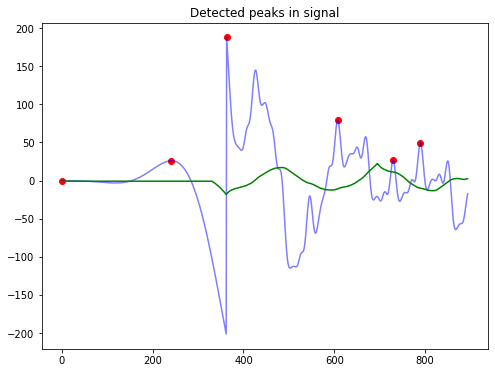

In [ ]:
fig_hr= plt.figure(figsize=(8,6))
ax5 = fig_hr.add_subplot(111)
ax5.set_title("Detected peaks in signal")
#ax6.set_xlim(0,2500)
ax5.plot(dataset.filt, alpha=0.5, color='blue') #Plot semi-transparent HR
ax5.plot(mov_avg, color ='green') #Plot moving average
ax5.scatter(peaklist, ybeat, color='red') #Plot detected peaks
                                            #Compute heart rate

In [ ]:
RR_list = []
cnt = 0
while (cnt < (len(peaklist)-1)):
    RR_interval = (peaklist[cnt+1] - peaklist[cnt]) #Calculate distance between beats in # of samples
    ms_dist = ((RR_interval / fs) * 1000.0) #Convert sample distances to ms distances
    RR_list.append(ms_dist) #Append to list
    cnt += 1

In [ ]:
bpm = 60000 / np.mean(RR_list) #60000 ms (1 minute) / average R-R interval of signal
print("\n\n\nAverage Heart Beat is: %.01f\n" %(bpm)) #Round off to 1 decimal and print
print("No of peaks in sample are {0}".format(len(peaklist)))




Average Heart Beat is: 126.5

No of peaks in sample are 6


## R-R interval location

In [ ]:
peaklist

[0, 241, 363, 608, 730, 790]

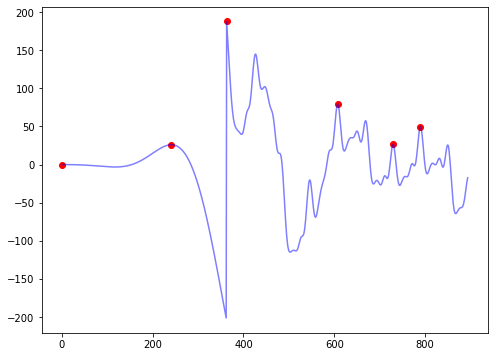

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(dataset.filt, alpha=0.5, color='blue')
plt.scatter(peaklist, ybeat, color='red')